# Homework - Deep learning for image classification


Let's train network to classify images from Tiny ImageNet!

Your homework contains three parts:

1. Make yourself familiar with ordinary training script structure and train good old vgg-like network
2. Improve quality with resnet-like network
3. Improve quality with test-time augmentation

But first of all let's take a look on data

# Tiny ImageNet dataset
In this homework we shall focus on the image recognition problem on Tiny Image Net dataset. This dataset contains
* 100k images of shape 3x64x64
* 200 different classes: snakes, spiders, cats, trucks, grasshopper, gull, etc.

In fact, it is a subset of ImageNet dataset with 4x downscaled images.

## Image examples



<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim3.png?raw=1" alt="Drawing" style="width:50%"/> </td>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tinyim2.png?raw=1" alt="Drawing" style="width:50%"/> </td>
</tr>


<tr>
    <td> <img src="https://github.com/yandexdataschool/Practical_DL/blob/sem3spring2019/week03_convnets/tiniim.png?raw=1" alt="Drawing" style="width:50%"/> </td>
</tr>

## Step 0 - data loading

In [1]:
#!S:bash
# if you are in colab, just add '!' in the start of the following line
# !wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img.py' -O tiny_img.py
# !wget --no-check-certificate 'https://raw.githubusercontent.com/yandexdataschool/deep_vision_and_graphics/fall21/homework01/tiny_img_dataset.py' -O tiny_img_dataset.py

In [2]:
#!L
# from tiny_img import download_tinyImg200
# data_path = '.'
# download_tinyImg200(data_path)

## Part 1. Training script structure and vgg-like network

In order to train a neural network for a specific task you should write code for 4 task-specific blocks and for one task-independed block:
1. data loader (data provider) - how to load and augment data for nn training
2. neural network architecture - what will be trained
3. loss function (+ auxilary metrics on train and validation set) - how to check neural network quality
4. optiimzer and training schedule - how neural network will be trained
5. "Train loop" - what exactly to do for each batch, how often to check validation error, how often to save network and so on. This code could be written in general way and reused between different training scripts


In [56]:
#!L
import torch
import torchvision
from torchvision import transforms
import tqdm
from IPython.display import clear_output

def get_computing_device():
    if torch.cuda.is_available():
        device = torch.device('cuda:0')
    else:
        device = torch.device('cpu')
    return device

device = get_computing_device()
print(f"Our main computing device is '{device}'")

Our main computing device is 'cuda:0'


### 1.1 Data loader and data augmentation
Normally there are two connected abstractions for data manipulation:
- Dataset (`torch.utils.data.Dataset` and its subclasses from `torchvision.datasets`) - some black-box that keeps and preprocesses separate elements of dataset. In particular, single sample augmentations live on this level usually.
- DataLoader (`torch.utils.data.DataLoader`) - structure that combines separate elements in batch.

Let's deal with training dataset. Here are some simple augmentations that we are going to use in our experiments:

In [4]:
import numpy as np
jitter_params = np.array([.5, .5, .5, .5])

train_trainsforms = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.RandomRotation(5),
     # YOUR CODE : examine torchvision.transforms package, find transformation for color jittering
     # and add it with proper parameters.
     transforms.ColorJitter(*jitter_params)
     # you may add any other transforms here
    ]
)

For training dataset we will use custom dataset that will keep all training data in RAM. If your amount of RAM memory is low, you can use `torchvision.datasets.ImageFolder()` instead.

In [5]:
#!L
import tiny_img_dataset
# you may use torchvision.datasets.ImageFolder() with the same parameters for loading train dataset 
train_dataset = tiny_img_dataset.TinyImagenetRAM('tiny-imagenet-200/train', transform=train_trainsforms)

tiny-imagenet-200/train: 100%|██████████| 200/200 [00:20<00:00,  9.89it/s]


Now validation. Take a look at `tiny-imagenet-200/val` folder and compare it with `tiny-imagenet-200/train`. Looks different, right? So we can't use `TinyImagenetRAM` for loading the validation set. Let's write a custom dataset instead but with the same behavior like `TinyImagenetRAM`.

In [6]:
from torch.utils.data import Dataset
import os
from PIL import Image

class TinyImagenetValDataset(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        super().__init__()

        self.root = root
        with open(os.path.join(root, 'val_annotations.txt')) as f:
            annotations = []
            for line in f:
                img_name, class_label = line.split('\t')[:2]
                annotations.append((img_name, class_label))

        # 1. define self.classes - list of sorted class labels from annotations
        # it should look like self.classes from "TinyImagenetRAM"
        # YOUR CODE
        self.classes = sorted(set([annot[1] for annot in annotations]))
        
        assert len(self.classes) == 200, len(self.classes)
        assert all(self.classes[i] < self.classes[i+1] for i in range(len(self.classes)-1)), 'classes should be ordered'
        assert all(isinstance(elem, type(annotations[0][1])) for elem in self.classes), 'your just need to reuse class_labels'

        # 2. self.class_to_idx - dict from class label to class index
        self.class_to_idx = {item: index for index, item in enumerate(self.classes)}

        self.transform = transform

        self.images, self.targets = [], []
        for img_name, class_name in tqdm.tqdm(annotations, desc=root):
            img_name = os.path.join(root, 'images', img_name)
            # 3. load image and store it in self.images (your may want to use tiny_img_dataset.read_rgb_image)
            # store the class index in self.targets
            # YOUR CODE
            image = tiny_img_dataset.read_rgb_image(img_name)
            
            assert image.shape == (64, 64, 3), image.shape
            self.images.append(Image.fromarray(image))
            self.targets.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.images)

    __getitem__ = tiny_img_dataset.TinyImagenetRAM.__getitem__

Let's finally load validation dataset. Normally you don't need to augment validation data.

In [7]:
val_dataset = TinyImagenetValDataset('tiny-imagenet-200/val', transform=transforms.ToTensor())

assert all(train_dataset.classes[i] == val_dataset.classes[i] for i in range(200)), \
    'class order in train and val datasets should be the same'
assert all(train_dataset.class_to_idx[elem] == val_dataset.class_to_idx[elem] for elem in train_dataset.classes), \
    'class indices should be the same'

tiny-imagenet-200/val:   0%|          | 0/10000 [00:00<?, ?it/s]

tiny-imagenet-200/val: 100%|██████████| 10000/10000 [00:01<00:00, 5023.33it/s]


For the most cases the default `DataLoader` will be good enough.

### 1.2 Neural network definition

"VGG-like network" usually means that the network is a sequence of convolutions with MaxPooling for downsampling. Here is a table from the original paper ["Very Deep Convolutional Networks for Large-Scale Image Recognition"](https://arxiv.org/abs/1409.1556) that describes classical configurations of VGG networks (often referred as VGG-A, VGG-B and so on using column name as an identificator or as VGG16, VGG19 and so on using amount of layers as an identificator)
![image.png](https://pytorch.org/assets/images/vgg.png)

These network configurations were designed for ImageNet dataset. Since images in tiny-imagenet are 4x downsampled, we are going to design our own configuration by reducing: 1) amount of layers; 2) amount of neurons in layers; 3) amount of maxpooling layers which downsample feature maps

Our network config will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

We use Conv(128) and GlobalAveragePooling instead of image flattening and FC layers for reducing the amount of parameters. 

In [10]:
#!L
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

And one more thing. VGG was designed before BatchNormalization was introduced. Nowadays it will be stupid if we don't use batch normalization in our network. So let's define simple module containing convolution, batch norm and relu in it and build our network using this module. Here is also implementation of GlobalAveragePooling given for you as example of custom module.

In [11]:
#!L
class GlobalAveragePool(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return torch.mean(x, dim=self.dim)

    
class ConvBNRelu(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding='same'):
        super().__init__()
        
        # YOUR CODE: define vars for convolution, batchnorm, relu
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # YOUR CODE: sequentially apply convolution, batchnorm, relu to 'x'
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x
    
    
def create_vgg_like_network(config=None):
    """
    Creates VGG like network according to config
    """
    model = nn.Sequential()
    
    default_config = [[16,16], [32, 32], [64, 64], [128, 128]]
    config = config or default_config
    
    in_channels = 3
    for block_index, block in enumerate(config):
        for i, out_channels in enumerate(block):
            # YOUR CODE: add ConvBNRelu module to model
            model.add_module(f"ConvBNRelu_{block_index}_{i}",
                             ConvBNRelu(in_channels, out_channels, 3))
            
            in_channels = out_channels
            
        if block_index != len(config) - 1:
            model.add_module(f'mp_{block_index}', nn.MaxPool2d(3, stride=2))
            
    model.add_module('pool', GlobalAveragePool(dim=(2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Here are our model created!

### 1.3 Loss function definition

Usually cross-entropy (negative log-likelihood) is used as loss function for image classification.

### 1.4 Optimizer and training schedule

Let's train our network using Adam with default parameters. 

For training by `torch.optim.SGD` you usually have to define training schedule - a way how to decrease learning rate during training. But since in adam all the gradients are scaled on their second momentum, the effect of a good training schedule is not so critical for training as in SGD. So we are going to act like lazy data scientists and will not decrease learning rate at all. But you may play with scheduling using for example `torch.optim.lr_scheduler.ExponentialLR`, see the [documentation](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) with explanation how to use it.

### 1.5 Training loop

Let's combine the previously defined things together.

In [14]:
import numpy as np
import time


def eval_model(model, data_generator):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in data_generator:
            X_batch = X_batch.to(device)
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

            
def train_model(model, optimizer, train_data_generator):
    train_loss = []
    model.train(True) # enable dropout / batch_norm training behavior
    for (X_batch, y_batch) in tqdm.tqdm(train_data_generator):
        optimizer.zero_grad()

        # forward
        # YOUR CODE: move X_batch, y_batch to 'device', compute model outputs on X_batch, 
        # run `compute_loss()` function
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        predictions = model(X_batch)
        loss = loss_fn(predictions, y_batch)

        # backward
        loss.backward()
        optimizer.step()

        # metrics
        train_loss.append(loss.cpu().data.numpy())
    return np.mean(train_loss)


In [15]:
import sys
sys.path.insert(0, "..")
from magic import reprint, _reprint
from plotter import History, Plotter

In [18]:
def train_loop(model, optimizer, train_data_generator, val_data_generator, num_epochs, history):
    """
    num_epochs - total amount of full passes over training data
    """
    plotter = Plotter(bound_history=history)
    for epoch in range(num_epochs):
        start_time = time.time()
        
        train_loss = train_model(model, optimizer, train_data_generator)
        
        val_accuracy = eval_model(model, val_data_generator)
        history.push_epoch({"loss (in-iteration)": train_loss},
                           {"accuracy": val_accuracy})

        # Then we print the results for this epoch:
        plotter.plot()
        print("Epoch {} of {} took {:.3f}s".format(epoch + 1, num_epochs, time.time() - start_time))
    return plotter

### 1.6 Training

All the preparation is done, time to run the training!

Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy here. 

In [31]:
#!L
batch_size = 64
train_batch_gen = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=batch_size,
                                              shuffle=True,
                                              num_workers=12)
#!L
val_batch_gen = torch.utils.data.DataLoader(val_dataset, 
                                            batch_size=batch_size,
                                            shuffle=False,
                                            num_workers=12)

model = create_vgg_like_network()
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters())

In [32]:
torch.cuda.empty_cache()

In [33]:
from plotter import History, Plotter
history = History()
plotter = train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30, history=history)

100%|██████████| 1563/1563 [00:19<00:00, 79.96it/s]


FigureWidget({
    'data': [],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'accuracy',
                                'x': 0.225,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'loss (in-iteration)',
                                'x': 0.775,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'height': 600,
               'showlegend': 

Epoch 1 of 30 took 20.943s


100%|██████████| 1563/1563 [00:19<00:00, 80.76it/s]


Epoch 2 of 30 took 20.701s


100%|██████████| 1563/1563 [00:19<00:00, 80.44it/s]


Epoch 3 of 30 took 20.822s


100%|██████████| 1563/1563 [00:19<00:00, 80.52it/s]


Epoch 4 of 30 took 20.761s


100%|██████████| 1563/1563 [00:19<00:00, 80.16it/s]


Epoch 5 of 30 took 20.869s


100%|██████████| 1563/1563 [00:19<00:00, 80.44it/s]


Epoch 6 of 30 took 20.774s


100%|██████████| 1563/1563 [00:19<00:00, 80.23it/s]


Epoch 7 of 30 took 20.825s


100%|██████████| 1563/1563 [00:19<00:00, 80.70it/s]


Epoch 8 of 30 took 20.723s


100%|██████████| 1563/1563 [00:19<00:00, 80.58it/s]


Epoch 9 of 30 took 20.748s


100%|██████████| 1563/1563 [00:19<00:00, 80.32it/s]


Epoch 10 of 30 took 20.834s


100%|██████████| 1563/1563 [00:19<00:00, 80.54it/s]


Epoch 11 of 30 took 20.767s


100%|██████████| 1563/1563 [00:19<00:00, 80.06it/s]


Epoch 12 of 30 took 20.894s


100%|██████████| 1563/1563 [00:19<00:00, 80.05it/s]


Epoch 13 of 30 took 20.908s


100%|██████████| 1563/1563 [00:19<00:00, 80.29it/s]


Epoch 14 of 30 took 20.845s


100%|██████████| 1563/1563 [00:19<00:00, 80.32it/s]


Epoch 15 of 30 took 20.850s


100%|██████████| 1563/1563 [00:19<00:00, 80.54it/s]


Epoch 16 of 30 took 20.736s


100%|██████████| 1563/1563 [00:19<00:00, 80.43it/s]


Epoch 17 of 30 took 20.790s


100%|██████████| 1563/1563 [00:19<00:00, 80.45it/s]


Epoch 18 of 30 took 20.787s


100%|██████████| 1563/1563 [00:19<00:00, 79.96it/s]


Epoch 19 of 30 took 20.912s


100%|██████████| 1563/1563 [00:19<00:00, 80.64it/s]


Epoch 20 of 30 took 20.734s


100%|██████████| 1563/1563 [00:19<00:00, 80.61it/s]


Epoch 21 of 30 took 20.753s


100%|██████████| 1563/1563 [00:19<00:00, 80.64it/s]


Epoch 22 of 30 took 20.760s


100%|██████████| 1563/1563 [00:19<00:00, 80.36it/s]


Epoch 23 of 30 took 21.013s


100%|██████████| 1563/1563 [00:19<00:00, 80.46it/s]


Epoch 24 of 30 took 20.809s


100%|██████████| 1563/1563 [00:19<00:00, 80.40it/s]


Epoch 25 of 30 took 20.799s


100%|██████████| 1563/1563 [00:19<00:00, 80.19it/s]


Epoch 26 of 30 took 20.859s


100%|██████████| 1563/1563 [00:19<00:00, 79.96it/s]


Epoch 27 of 30 took 20.882s


100%|██████████| 1563/1563 [00:19<00:00, 80.42it/s]


Epoch 28 of 30 took 20.797s


100%|██████████| 1563/1563 [00:19<00:00, 79.87it/s]


Epoch 29 of 30 took 20.925s


100%|██████████| 1563/1563 [00:19<00:00, 80.54it/s]


Epoch 30 of 30 took 20.758s


In [36]:
from magic import display_no_widgets
display_no_widgets(plotter)

## Part 2. Say Hello to ResNets

In this part you need to redefine your model, all the rest will be the same. As with VGG, we are going to define ResNet-like model, not a classic architecture, designed for ImageNet classification.

"ResNet-like" usually means that your network consists of "residual blocks". There are two types of blocks that widely used: with two convolutions and with three convolutions:
![resnet_blocks](https://miro.medium.com/max/613/1*zS2ChIMwAqC5DQbL5yD9iQ.png)

In practice, blocks with three convolutions are used often since they allows to build more deep network with less parameters. Blocks with two convolutions are usually used for comparisson with non-residual networks, espatially with VGG and AlexNet.

Here is a table from the paper "[Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)" that describes classical configurations of ResNet networks. Usually they are referred as ResNet-18, ResNet-34 and so on using amount of layers as identificator. Note, that networks starting from ResNet-50 are based on 3-convolutional blocks. In fact ResNet-18 and ResNet-34 were introduces just for comparison with VGG, while ResNet-50 is what usually used in practice as a good baseline.

![img](https://miro.medium.com/max/2400/1*aq0q7gCvuNUqnMHh4cpnIw.png)

As with VGG, we are going to build our own config for network. Let's use 2-convolutional blocks for comparisson with vgg and take network like [Conv7x7 - 32] + [conv32-block, conv32-block] + [conv64-block, conv64-block] + [conv128-block, conv128-block] + [GlobalAveragePooling] + fc200 + softmax

Comparing to ResNet18, we decreased the amount of filters and removed max-pooling in the beggining and the last set of convolutions for keeping meaningful spatial resolution.

In [50]:
class ResNetBlock2(nn.Module):
    """
    Module implements the following function:
    
    output = relu(F(input) + Residual(input)), where: 
        Residual(x) = Conv + bn + relu + conv + bn
        F(x) = x                                        , if in_channels == out_channels and stride == 1
             = Conv1x1(in_channel, out_channel, stride) , otherwise
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        # YOUR CODE: define conv1, bn1, relu1, conv2, bn2 for residual branch computation 
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size, padding="same")
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.relu2 = nn.ReLU()
        
        self.conv3 = None  # conv for main branch adopatation
        if in_channels != out_channels or stride != 1:
            self.conv3 = nn.Conv2d(in_channels, out_channels, 1, stride, padding=0)
        
    def forward(self, x):
        # YOUR CODE: compute residual branch, 
        # DON'T OVERRIDE 'x' as you will need it 
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.relu1(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)
        
        if self.conv3 is not None:
            x = self.conv3(x)
        
        result = self.relu2(residual + x)
        return result

def create_resnet_like_network():
    model = nn.Sequential()
    
    config = [[32, 32], [64, 64], [128, 128]]
    model.add_module('init_conv', ConvBNRelu(3, 32, kernel_size=7, stride=2, padding=3))
    
    in_channels = 32
    for i in range(len(config)):
        for j in range(len(config[i])):
            out_channels = config[i][j]
            stride = 2 if i != 0 and j == 0 else 1
            padding="same" if stride == 1 else 1
            # YOUR CODE: add ResNetBlock2 module to model
            model.add_module(f"resnet_block_{i}_{j}",
                             ResNetBlock2(in_channels, out_channels, stride=stride, padding=padding))
            
            in_channels = out_channels
    model.add_module('pool', GlobalAveragePool((2,3)))
    model.add_module('logits', nn.Linear(out_channels, 200))
    return model

Let's train our network then. Normally after training for 30 epochs you should get a neural network that predicts labels with >40% accuracy and gives near +1% profit to vgg-like network from the previous experiment.

In [51]:
# YOUR CODE: create resnet model, move it to 'device', create same optimizer as in previous experiment
model = create_resnet_like_network().to(device)
opt = torch.optim.Adam(model.parameters())
history = History()
plotter = train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30, history=history)
clear_output()
display_no_widgets(plotter)

  0%|          | 0/1563 [00:00<?, ?it/s]

100%|██████████| 1563/1563 [00:27<00:00, 57.62it/s]


FigureWidget({
    'data': [],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'accuracy',
                                'x': 0.225,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'loss (in-iteration)',
                                'x': 0.775,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'height': 600,
               'showlegend': 

Epoch 1 of 30 took 29.153s


100%|██████████| 1563/1563 [00:27<00:00, 56.15it/s]


Epoch 2 of 30 took 29.736s


100%|██████████| 1563/1563 [00:27<00:00, 56.09it/s]


Epoch 3 of 30 took 29.773s


100%|██████████| 1563/1563 [00:27<00:00, 56.92it/s]


Epoch 4 of 30 took 29.286s


100%|██████████| 1563/1563 [00:27<00:00, 57.80it/s]


Epoch 5 of 30 took 28.857s


100%|██████████| 1563/1563 [00:27<00:00, 57.25it/s]


Epoch 6 of 30 took 29.172s


100%|██████████| 1563/1563 [00:27<00:00, 56.55it/s]


Epoch 7 of 30 took 29.486s


100%|██████████| 1563/1563 [00:27<00:00, 56.79it/s]


Epoch 8 of 30 took 29.394s


100%|██████████| 1563/1563 [00:27<00:00, 56.58it/s]


Epoch 9 of 30 took 29.511s


100%|██████████| 1563/1563 [00:27<00:00, 56.55it/s]


Epoch 10 of 30 took 29.476s


100%|██████████| 1563/1563 [00:27<00:00, 56.58it/s]


Epoch 11 of 30 took 29.506s


100%|██████████| 1563/1563 [00:27<00:00, 56.62it/s]


Epoch 12 of 30 took 29.470s


100%|██████████| 1563/1563 [00:27<00:00, 56.99it/s]


Epoch 13 of 30 took 29.295s


100%|██████████| 1563/1563 [00:27<00:00, 56.53it/s]


Epoch 14 of 30 took 29.531s


100%|██████████| 1563/1563 [00:27<00:00, 56.77it/s]


Epoch 15 of 30 took 29.408s


100%|██████████| 1563/1563 [00:27<00:00, 56.54it/s]


Epoch 16 of 30 took 29.505s


100%|██████████| 1563/1563 [00:26<00:00, 59.30it/s]


Epoch 17 of 30 took 28.187s


100%|██████████| 1563/1563 [00:26<00:00, 59.54it/s]


Epoch 18 of 30 took 28.043s


100%|██████████| 1563/1563 [00:27<00:00, 57.23it/s]


Epoch 19 of 30 took 29.211s


100%|██████████| 1563/1563 [00:27<00:00, 57.32it/s]


Epoch 20 of 30 took 29.306s


100%|██████████| 1563/1563 [00:27<00:00, 57.32it/s]


Epoch 21 of 30 took 29.109s


100%|██████████| 1563/1563 [00:27<00:00, 57.12it/s]


Epoch 22 of 30 took 29.197s


100%|██████████| 1563/1563 [00:26<00:00, 58.11it/s]


Epoch 23 of 30 took 28.675s


100%|██████████| 1563/1563 [00:26<00:00, 59.69it/s]


Epoch 24 of 30 took 27.982s


100%|██████████| 1563/1563 [00:27<00:00, 56.90it/s]


Epoch 25 of 30 took 29.339s


100%|██████████| 1563/1563 [00:27<00:00, 57.21it/s]


Epoch 26 of 30 took 29.223s


100%|██████████| 1563/1563 [00:27<00:00, 57.18it/s]


Epoch 27 of 30 took 29.186s


100%|██████████| 1563/1563 [00:27<00:00, 56.86it/s]


Epoch 28 of 30 took 29.387s


100%|██████████| 1563/1563 [00:27<00:00, 57.20it/s]


Epoch 29 of 30 took 29.187s


100%|██████████| 1563/1563 [00:27<00:00, 56.71it/s]


Epoch 30 of 30 took 29.386s


In [53]:

display_no_widgets(plotter)

If you were attentive to our resnet network, you may notice that it has almost 2x more parameters and 2x deeper than vgg-like network. Let's define comparable vgg-like network by doubling amount of conv layers.

Our new vgg-like architecture will be [Conv(16), Conv(16), MaxPool] + [Conv(32), Conv(32), Conv(32), Conv(32), MaxPool] + [Conv(64), Conv(64), Conv(64), Conv(64), MaxPool] + [Conv(128), Conv(128), Conv(128), Conv(128)] + [GlobalAveragePooling] + [FC(200) + softmax]

In [55]:
model = create_vgg_like_network(config=[[16,16], [32,32,32,32], [64, 64, 64, 64], [128, 128, 128, 128]])
model = model.to(device)
opt = torch.optim.Adam(model.parameters())
history = History()
plotter = train_loop(model, opt, train_batch_gen, val_batch_gen, num_epochs=30, history=history)
clear_output()
display_no_widgets(plotter)

  0%|          | 0/1563 [00:00<?, ?it/s]

100%|██████████| 1563/1563 [00:25<00:00, 60.78it/s]


FigureWidget({
    'data': [],
    'layout': {'annotations': [{'font': {'size': 16},
                                'showarrow': False,
                                'text': 'accuracy',
                                'x': 0.225,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'loss (in-iteration)',
                                'x': 0.775,
                                'xanchor': 'center',
                                'xref': 'paper',
                                'y': 1.0,
                                'yanchor': 'bottom',
                                'yref': 'paper'}],
               'height': 600,
               'showlegend': 

Epoch 1 of 30 took 27.364s


100%|██████████| 1563/1563 [00:26<00:00, 60.01it/s]


Epoch 2 of 30 took 27.690s


100%|██████████| 1563/1563 [00:24<00:00, 63.66it/s]


Epoch 3 of 30 took 26.164s


100%|██████████| 1563/1563 [00:25<00:00, 61.87it/s]


Epoch 4 of 30 took 26.878s


100%|██████████| 1563/1563 [00:25<00:00, 61.88it/s]


Epoch 5 of 30 took 26.863s


100%|██████████| 1563/1563 [00:25<00:00, 62.05it/s]


Epoch 6 of 30 took 26.787s


100%|██████████| 1563/1563 [00:25<00:00, 61.97it/s]


Epoch 7 of 30 took 26.862s


100%|██████████| 1563/1563 [00:25<00:00, 61.73it/s]


Epoch 8 of 30 took 26.938s


100%|██████████| 1563/1563 [00:25<00:00, 60.52it/s]


Epoch 9 of 30 took 27.424s


100%|██████████| 1563/1563 [00:25<00:00, 61.96it/s]


Epoch 10 of 30 took 27.019s


100%|██████████| 1563/1563 [00:24<00:00, 63.60it/s]


Epoch 11 of 30 took 26.238s


100%|██████████| 1563/1563 [00:24<00:00, 63.22it/s]


Epoch 12 of 30 took 26.296s


100%|██████████| 1563/1563 [00:24<00:00, 64.32it/s]


Epoch 13 of 30 took 25.931s


100%|██████████| 1563/1563 [00:24<00:00, 63.62it/s]


Epoch 14 of 30 took 26.106s


100%|██████████| 1563/1563 [00:25<00:00, 61.61it/s]


Epoch 15 of 30 took 26.968s


100%|██████████| 1563/1563 [00:24<00:00, 63.67it/s]


Epoch 16 of 30 took 26.139s


100%|██████████| 1563/1563 [00:24<00:00, 63.36it/s]


Epoch 17 of 30 took 26.273s


100%|██████████| 1563/1563 [00:24<00:00, 63.39it/s]


Epoch 18 of 30 took 26.229s


100%|██████████| 1563/1563 [00:24<00:00, 63.46it/s]


Epoch 19 of 30 took 26.214s


100%|██████████| 1563/1563 [00:24<00:00, 64.82it/s]


Epoch 20 of 30 took 25.913s


100%|██████████| 1563/1563 [00:23<00:00, 65.60it/s]


Epoch 21 of 30 took 25.454s


100%|██████████| 1563/1563 [00:24<00:00, 64.94it/s]


Epoch 22 of 30 took 25.608s


100%|██████████| 1563/1563 [00:23<00:00, 67.19it/s]


Epoch 23 of 30 took 24.771s


100%|██████████| 1563/1563 [00:23<00:00, 66.08it/s]


Epoch 24 of 30 took 25.210s


100%|██████████| 1563/1563 [00:24<00:00, 65.02it/s]


Epoch 25 of 30 took 25.647s


100%|██████████| 1563/1563 [00:24<00:00, 64.65it/s]


Epoch 26 of 30 took 26.090s


100%|██████████| 1563/1563 [00:24<00:00, 65.01it/s]


Epoch 27 of 30 took 25.616s


100%|██████████| 1563/1563 [00:25<00:00, 62.34it/s]


Epoch 28 of 30 took 26.609s


100%|██████████| 1563/1563 [00:24<00:00, 63.30it/s]


Epoch 29 of 30 took 26.261s


100%|██████████| 1563/1563 [00:24<00:00, 64.55it/s]


Epoch 30 of 30 took 25.776s


NameError: name 'clear_output' is not defined

In [57]:

display_no_widgets(plotter)

Do you see the profit from residual connections? 

The quality of vgg network in this experiment could be even worse than the quality of vgg network in the first experiment. This is due to gradient vanishing problem that makes it hard to train deep neural networks without residual conections.

## Part 3. Test time augmentations

Test-time augmentation (TTA) is a powerful techneque that allows you to trade inference time for quality. The main idea is as follows. As for train data augmentation, you may use some image transformations to generate new representations of the input image and expect that on these representations properly trained network provides consistent predictions. These predictions can be averaged then in order to get more stable prediction. 

In [58]:
model_accuracy = eval_model(model, val_batch_gen)
print(f"Trained model accuracy: {model_accuracy}")

Trained model accuracy: 0.3919187898089172


In [59]:
def eval_model_with_tta(model, data_generator, transformations, n_transformations):
    accuracy = []
    model.train(False) # disable dropout / use averages for batch_norm
    with torch.no_grad():
        for X_batch, y_batch in tqdm.tqdm(data_generator):
            logits_per_transform = []
            for _ in range(n_transformations):
                # YOUR CODE: apply transformations to X_batch, move batch to device, run forward pass
                # DON"T OVERRIDE X_batch
                X_batch_transformed = transformations(X_batch).to(device)
                logits = model(X_batch_transformed)
                
                logits_per_transform.append(logits)
                
            # YOUR CODE: stack logits_per_transform and calculate mean over stacked dimension
            averaged_logits = torch.dstack(logits_per_transform).mean(dim=-1)

            y_pred = averaged_logits.max(dim=1)[1].data
            accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy()))
    return np.mean(accuracy)

In [60]:
tta_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(*jitter_params * .4)
    # jittering comparing to augmentation on train set in order to reduce variance
])

In [61]:
n_forwards = [1]
tta_accuracy = [model_accuracy]
for i in [3, 5, 7, 9, 13, 15]:
    tta_accuracy.append(eval_model_with_tta(model, val_batch_gen, tta_transformations, n_transformations=i))
    n_forwards.append(i)
    print(f"Model accuracy with {n_forwards[-1]} forward runs is {tta_accuracy[-1]}")

100%|██████████| 157/157 [00:09<00:00, 16.34it/s]


Model accuracy with 3 forward runs is 0.40625


100%|██████████| 157/157 [00:15<00:00, 10.32it/s]


Model accuracy with 5 forward runs is 0.4114251592356688


100%|██████████| 157/157 [00:20<00:00,  7.57it/s]


Model accuracy with 7 forward runs is 0.40893710191082805


100%|██████████| 157/157 [00:26<00:00,  5.98it/s]


Model accuracy with 9 forward runs is 0.4164012738853503


100%|██████████| 157/157 [00:35<00:00,  4.44it/s]


Model accuracy with 13 forward runs is 0.4124203821656051


100%|██████████| 157/157 [00:41<00:00,  3.76it/s]

Model accuracy with 15 forward runs is 0.412718949044586


Let's visualize what we have computed

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Test time augmentation results')

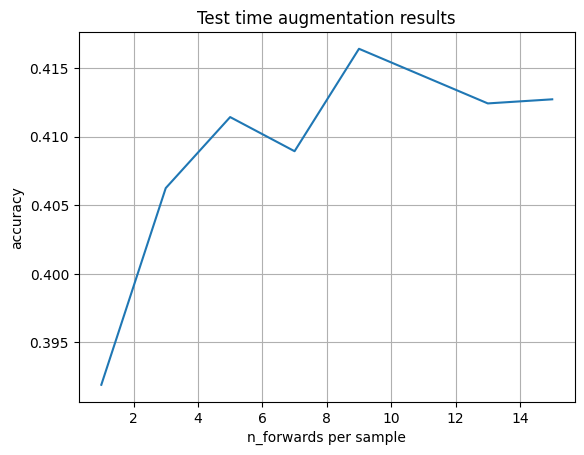

In [63]:
plt.plot(n_forwards, tta_accuracy)
plt.grid()
plt.xlabel('n_forwards per sample')
plt.ylabel('accuracy')
plt.title('Test time augmentation results')

Normally you should get 1-2% improvement of accuracy here.

## What's next?
Introducing of residual blocks played a big role in deep learning and allowed to train deep (and I mean really [DEEP](https://github.com/KaimingHe/resnet-1k-layers/blob/master/resnet-pre-act.lua#L2)) networks. Many modern architectures include such layer or its variation. For deeper understanding of influence of skip connections you can read the following papers:
1. ["Residual Networks Behave Like Ensembles of
Relatively Shallow Networks"](https://arxiv.org/pdf/1605.06431.pdf) - interesting point of view on residual blocks showing that statement "skip connections solves vanishing gradients problem" is ambigious in some way
2. ["Identity Mappings in Deep Residual Networks"](https://arxiv.org/pdf/1603.05027.pdf) ([short summary](https://towardsdatascience.com/resnet-with-identity-mapping-over-1000-layers-reached-image-classification-bb50a42af03e)) - study and comparison of different residual blocks variations showing that preserving "identity path" through the network improves quality
3. ["Visualizing the Loss Landscape of Neural Nets"](https://arxiv.org/pdf/1712.09913.pdf) - some attempts on loss function visualization showed how skip-connections affect loss landscape